In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1. 데이터 읽기 & 날짜 정렬
df = pd.read_csv("/content/drive/MyDrive/25-2ML/USD_KRW_preproc.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(by="Date", ascending=True).reset_index(drop=True)

# 2. features와 dates 분리 (features에서 날짜 제외!)
features = ["Price", "Open", "High", "Low"]
dates = df["Date"].values  # 전체 날짜 보관

# 3. 결측치 제거
df = df.dropna(subset=features).reset_index(drop=True)  # features에 결측치 있는 행만 제거

# 4. 스케일링
scaled = (df[features] - df[features].mean()) / df[features].std()

In [3]:
def create_dataset(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size][0])  # "Price" 컬럼 (index 0)
    return np.array(X), np.array(y)

window_size = 30
X, y = create_dataset(scaled.values, window_size)
dates = dates[window_size:]  # window_size 이후 구간의 날짜만 사용

# 6. Train/Test Split (날짜 포함)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
test_dates = dates[split:]  # test set에 해당하는 날짜

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

In [4]:
model = models.Sequential([
    layers.Conv1D(filters=32, kernel_size=3, padding="causal", activation="relu",
                  input_shape=(window_size, len(features))),
    layers.Conv1D(filters=32, kernel_size=3, padding="causal", activation="relu"),
    layers.MaxPooling1D(pool_size=2),
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(32),
    layers.Dense(32, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1)
])

model.compile(optimizer="adam", loss="mse")
model.summary()

history = model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=32,
    validation_split=0.1
)

pred = model.predict(X_test)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 30, 32)         │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 30, 32)         │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 15, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 15, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,369 (165.50 KB)

 Trainable params: 42,369 (165.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.2318 - val_loss: 0.0491
Epoch 2/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0298 - val_loss: 0.0544
Epoch 3/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0227 - val_loss: 0.0319
Epoch 4/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0192 - val_loss: 0.0348
Epoch 5/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0178 - val_loss: 0.0263
Epoch 6/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0146 - val_loss: 0.0365
Epoch 7/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0161 - val_loss: 0.0448
Epoch 8/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0117 - val_loss: 0.0682
Epoch 9/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0107 - val_loss: 0.0187
Epoch 10/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0091 - val_loss: 0.0367
Epoch 11/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0098 - val_loss: 0.0159
Epoch 12/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0084 - va

In [5]:
price_mean = df["Price"].mean()
price_std = df["Price"].std()

y_test_denorm = y_test * price_std + price_mean
pred_denorm = pred.flatten() * price_std + price_mean

# 9. 에러 계산
mse = (y_test_denorm - pred_denorm)**2
rmse = np.sqrt(mse)

# 10. SHAPE CHECK (꼭 확인!)
print('test_dates:', test_dates.shape)
print('y_test_denorm:', y_test_denorm.shape)
print('pred_denorm:', pred_denorm.shape)

test_dates: (516,)
y_test_denorm: (516,)
pred_denorm: (516,)


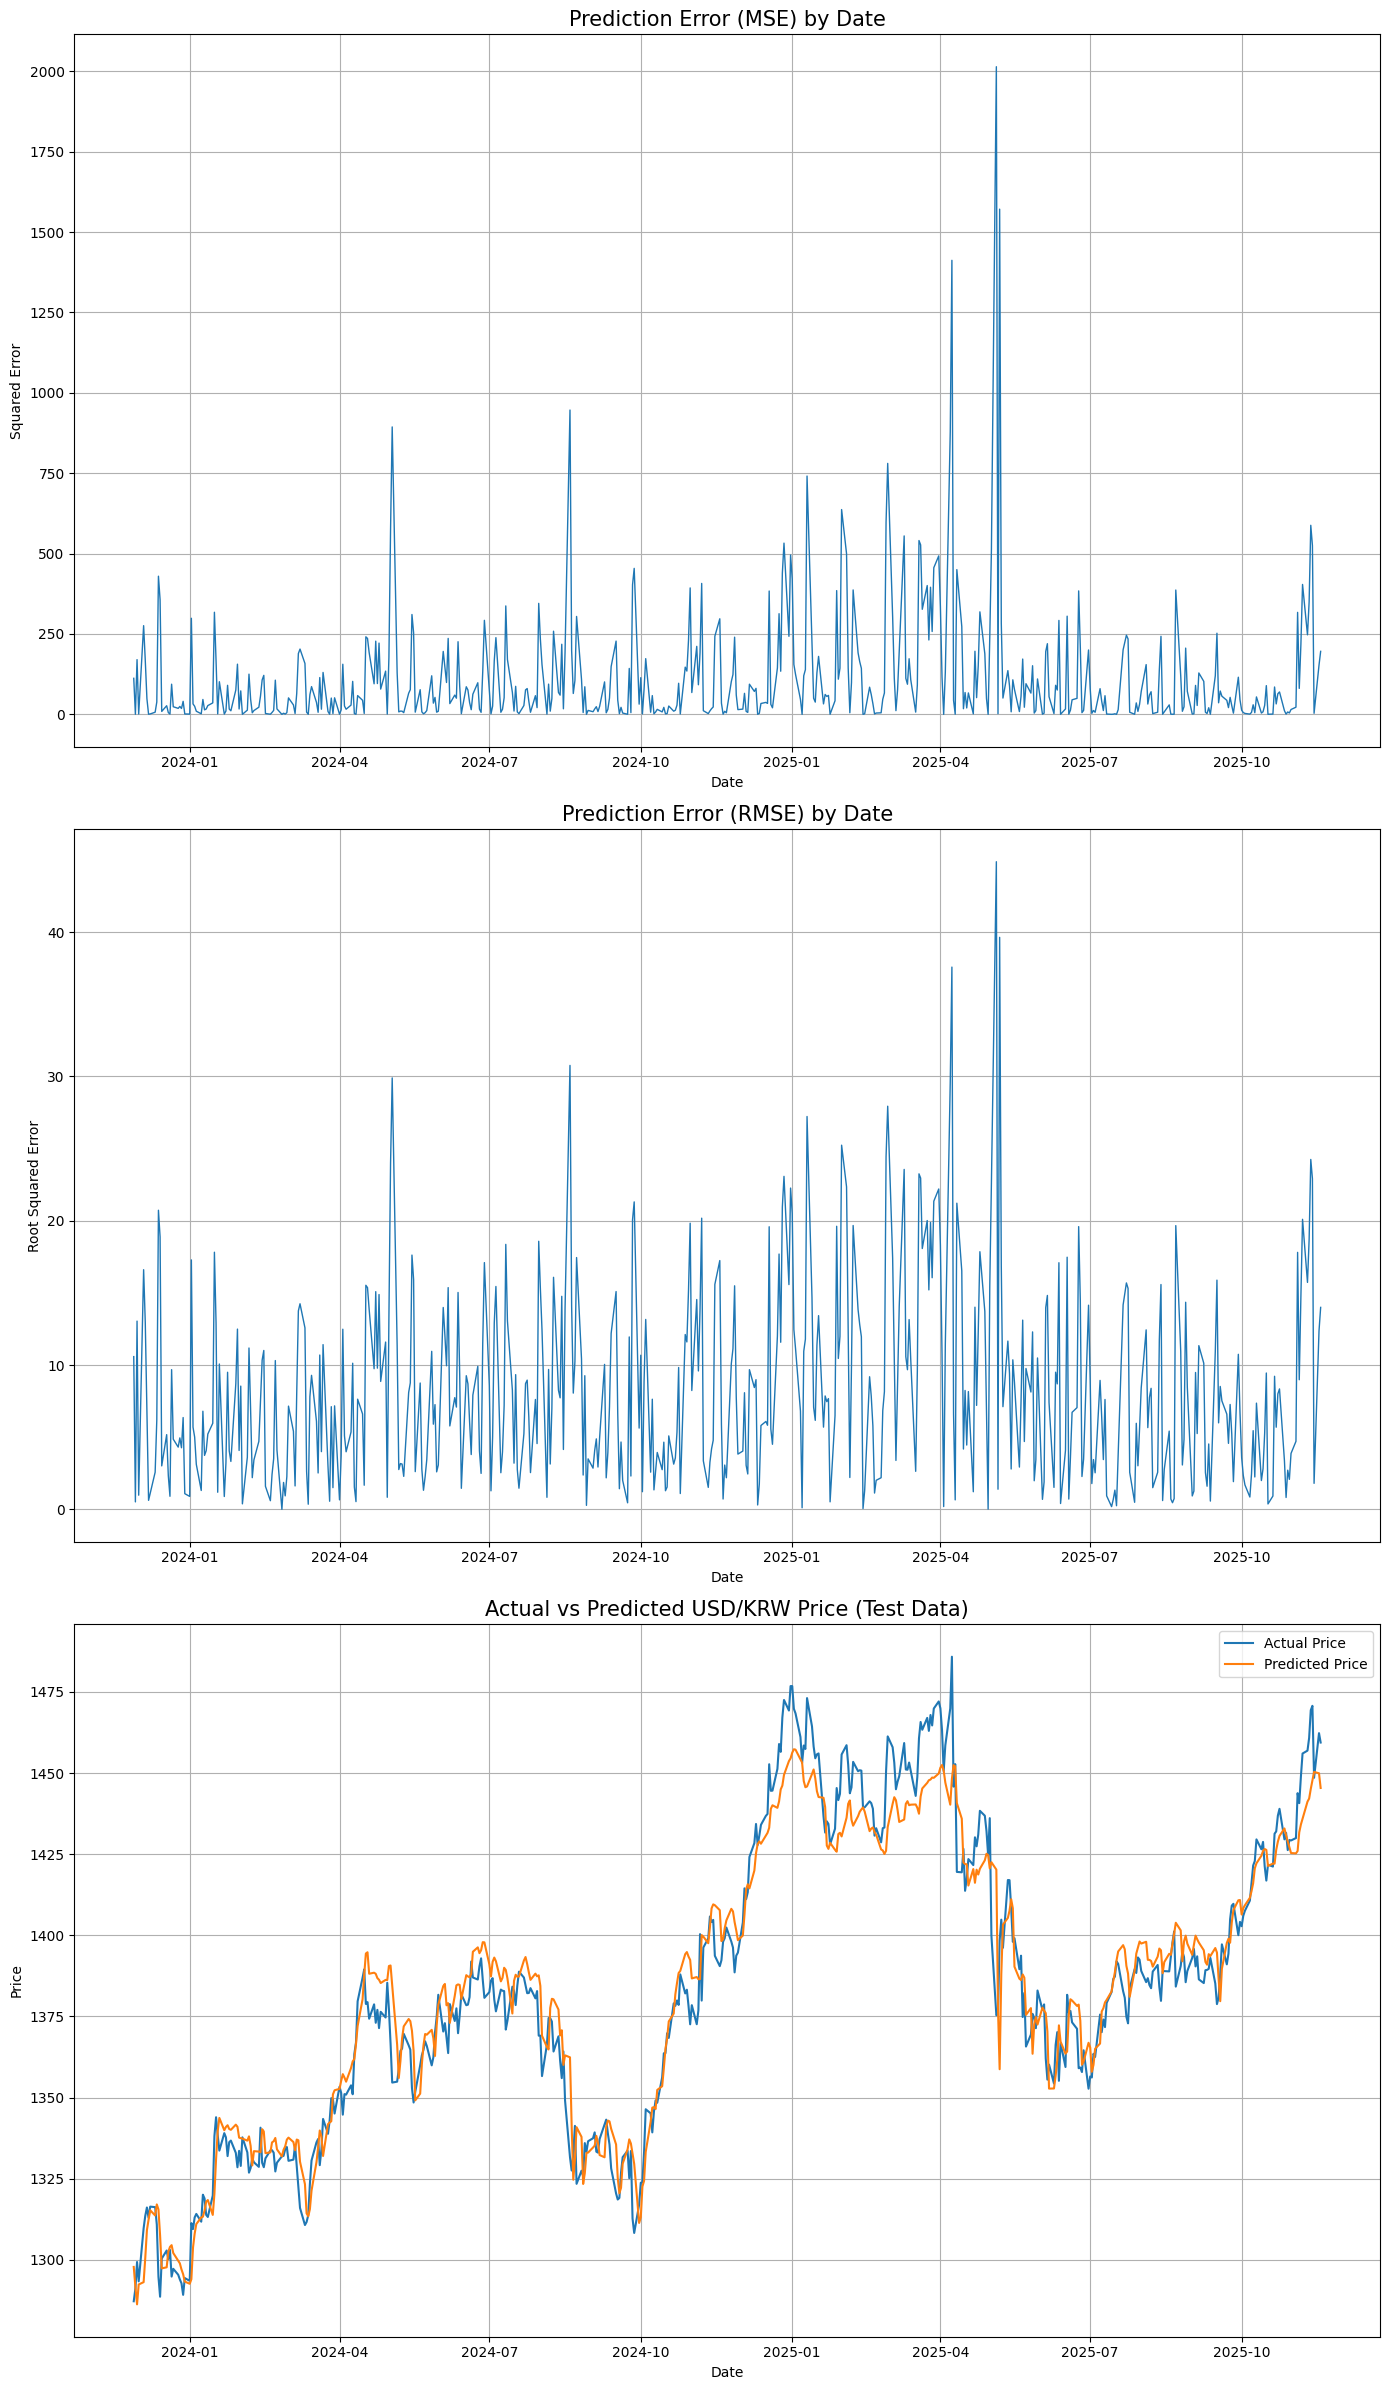

In [6]:
# 11. 시각화
plt.figure(figsize=(14, 24))

# (1) MSE Plot
plt.subplot(3, 1, 1)
plt.plot(test_dates, mse, linewidth=1)
plt.title("Prediction Error (MSE) by Date", fontsize=15)
plt.xlabel("Date")
plt.ylabel("Squared Error")
plt.grid(True)

# (2) RMSE Plot
plt.subplot(3, 1, 2)
plt.plot(test_dates, rmse, linewidth=1)
plt.title("Prediction Error (RMSE) by Date", fontsize=15)
plt.xlabel("Date")
plt.ylabel("Root Squared Error")
plt.grid(True)

# (3) Actual vs Predicted Plot
plt.subplot(3, 1, 3)
plt.plot(test_dates, y_test_denorm, label="Actual Price", linewidth=1.5)
plt.plot(test_dates, pred_denorm, label="Predicted Price", linewidth=1.5)
plt.title("Actual vs Predicted USD/KRW Price (Test Data)", fontsize=15)
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()